In [1]:
%matplotlib inline

import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import sys
import multiprocessing as mp
from collections import OrderedDict
import cartopy.crs as ccrs

from tonic.io import read_configobj
import timeit

from analysis_utils import (
    rmse, find_global_param_value, determine_tile_frac, get_soil_depth,
    load_nc_file, setup_output_dirs, calc_sm_runoff_corrcoef,
    to_netcdf_state_file_compress, calculate_rmse, calculate_pbias,
    add_gridlines)

In [2]:
# ========================================================== #
# Command line arguments
# ========================================================== #
# --- Load in config file --- #
cfg = read_configobj('/civil/hydro/ymao/data_assim/tools/plot_analyze_results/' \
                     'cfg/20170815.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param.synthetic/' \
                     'plot.synth.random1.cfg')

In [3]:
# ========================================================== #
# Parameter setting
# ========================================================== #
# --- Input directory and files --- #
# gen_synthetic results
gen_synth_basedir = cfg['SYNTHETIC']['gen_synth_basedir']
truth_nc_filename = cfg['SYNTHETIC']['truth_nc_filename']
synth_meas_nc_filename = cfg['SYNTHETIC']['synth_meas_nc_filename']

# openloop
openloop_basedir = cfg['SYNTHETIC']['openloop_basedir']

# Time period
start_time = pd.to_datetime(cfg['SYNTHETIC']['start_time'])
end_time = pd.to_datetime(cfg['SYNTHETIC']['end_time'])
start_year = start_time.year
end_year = end_time.year

# VIC global file template (for extracting param file and snow_band)
vic_global_txt = cfg['SYNTHETIC']['vic_global_txt']

# Forcings (for all basepaths, 'YYYY.nc' will be appended)
orig_force_basepath = cfg['SYNTHETIC']['orig_force_basepath']
truth_force_basepath = cfg['SYNTHETIC']['truth_force_basepath']
# ens_force_basedir/ens_<i>/force.<YYYY>.nc, where <i> = 1, 2, ..., N
ens_force_basedir = cfg['SYNTHETIC']['ens_force_basedir']

# VIC parameter netCDF file
vic_param_nc = cfg['SYNTHETIC']['vic_param_nc']

# Domain netCDF file
domain_nc = cfg['SYNTHETIC']['domain_nc']

# --- Measurement times --- #
meas_times = pd.date_range(
    cfg['SYNTHETIC']['meas_start_time'],
    cfg['SYNTHETIC']['meas_end_time'],
    freq=cfg['SYNTHETIC']['freq'])

# --- Plot time period --- #
plot_start_time = pd.to_datetime(cfg['SYNTHETIC']['plot_start_time'])
plot_end_time = pd.to_datetime(cfg['SYNTHETIC']['plot_end_time'])
plot_start_year = plot_start_time.year
plot_end_year = plot_end_time.year

# --- Output --- #
output_rootdir = cfg['OUTPUT']['output_dir']

In [4]:
# ========================================================== #
# Setup output data dir
# ========================================================== #
output_data_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['data'])['data']

output_maps_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['maps'])['maps']

output_ts_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['time_series'])['time_series']

In [5]:
# ========================================================== #
# Load data
# ========================================================== #
print('Loading data...')

# --- Domain --- #
da_domain = xr.open_dataset(domain_nc)['mask']

# --- Tile fraction --- #
da_tile_frac = determine_tile_frac(vic_global_txt)  # [veg_class, snow_band, lat, lon]

# --- Openloop --- #
print('\tOpenloop history...')
openloop_hist_nc = os.path.join(
    openloop_basedir,
    'history',
    'history.openloop.{}-{:05d}.nc'.format(
        start_time.strftime('%Y-%m-%d'),
        start_time.hour*3600+start_time.second))
ds_openloop_hist = xr.open_dataset(openloop_hist_nc)
print('\tOpenloop states...')
openloop_state_nc = os.path.join(
    openloop_basedir,
    'states',
    'openloop_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_openloop_states = xr.open_dataset(openloop_state_nc)

# --- Truth --- #
print('\tTruth history...')
ds_truth_hist = xr.open_dataset(os.path.join(
        gen_synth_basedir, 'truth',
        'history', truth_nc_filename))
print('\tTruth states...')
truth_state_nc = os.path.join(
    gen_synth_basedir,
    'truth',
    'states',
    'truth_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_truth_states = xr.open_dataset(truth_state_nc)

# --- Measurement --- #
print('\tMeasurements...')
da_meas = xr.open_dataset(os.path.join(
    gen_synth_basedir, 'synthetic_meas', synth_meas_nc_filename))['simulated_surface_sm']

Loading data...
	Openloop history...
	Openloop states...
	Truth history...
	Truth states...
	Measurements...


In [6]:
# --- Forcing, openloop --- #
ds_openloop_prec_nc = '{}prec.{}_{}.nc'.format(orig_force_basepath, start_year, end_year)
if not os.path.isfile(ds_openloop_prec_nc):  # if RMSE is not already calculated
    # Load all years of forcing data
    list_da = []
    for year in range(start_year, end_year+1):
        force_nc = '{}{}.nc'.format(orig_force_basepath, year)
        list_da.append(xr.open_dataset(force_nc)['PREC'])
    da_openloop_prec = xr.concat(list_da, dim='time')
    # Save to netCDF file
    ds_openloop_prec = xr.Dataset({'PREC': da_openloop_prec})
    ds_openloop_prec.to_netcdf(ds_openloop_prec_nc, format='NETCDF4_CLASSIC')
else:
    da_openloop_prec = xr.open_dataset(ds_openloop_prec_nc)['PREC']

In [7]:
# --- Perfect-all-state, orig. forcing --- #
print('\ttruthStates_origP...')
ds_truthStateOrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_states_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SM1, orig. forcing --- #
print('\ttruthSM1_origP...')
ds_truthSM1OrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_sm1_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SM2, orig. forcing --- #
print('\ttruthSM2_origP...')
ds_truthSM2OrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_sm2_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SM3, orig. forcing --- #
print('\ttruthSM3_origP...')
ds_truthSM3OrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_sm3_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SWE, orig. forcing --- #
print('\ttruthSWE_origP...')
ds_truthSWEOrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_swe_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

	truthStates_origP...
	truthSM1_origP...
	truthSM2_origP...
	truthSM3_origP...
	truthSWE_origP...


In [8]:
# ======================================================== #
# Extract shared coordinates
# ======================================================== #
lat_coord = da_domain['lat']
lon_coord = da_domain['lon']

In [9]:
# ======================================================== #
# Extract soil layer depths
# ======================================================== #
da_soil_depth = get_soil_depth(vic_param_nc)  # [nlayer, lat, lon]
depth_sm1 = da_soil_depth.sel(nlayer=0)  # [lat, lon]
depth_sm2 = da_soil_depth.sel(nlayer=1)  # [lat, lon]
depth_sm3 = da_soil_depth.sel(nlayer=2)  # [lat, lon]

In [10]:
# ======================================================== #
# Calculate RMSE(SM_openloop)
# ======================================================== #
print('Calculating RMSE(SM_openloop)')
# === sm1 === #
print('\tsm1')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_sm1.nc')
da_rmse_openloop_sm1 = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='sm1', depth_sm=depth_sm1)
# === sm2 === #
print('\tsm2')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_sm2.nc')
da_rmse_openloop_sm2 = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='sm2', depth_sm=depth_sm2)
# === sm3 === #
print('\tsm3')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_sm3.nc')
da_rmse_openloop_sm3 = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='sm3', depth_sm=depth_sm3)
# === SWE === #
print('\tSWE')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_swe.nc')
da_rmse_openloop_swe = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='swe')

Calculating RMSE(SM_openloop)
	sm1
	sm2
	sm3
	SWE


In [11]:
# ======================================================== #
# Calculate RMSE(runoff_openloop) - daily
# ======================================================== #
print('Calculating RMSE(runoff_openloop) - daily')
# === Surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_dailyRunoff.nc')
da_rmse_openloop_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='runoff_daily')
# === Baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_dailyBaseflow.nc')
da_rmse_openloop_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='baseflow_daily')
# === Total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_dailyTotrunoff.nc')
da_rmse_openloop_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='totrunoff_daily')

Calculating RMSE(runoff_openloop) - daily
	surface runoff
	baseflow
	total runoff


In [12]:
# ======================================================== #
# Calculate RMSE(runoffLog_openloop) - daily
# ======================================================== #
print('Calculating RMSE(runoffLog_openloop) - daily')
# === Surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'rmseLog_openloop_dailyRunoff.nc')
da_rmseLog_openloop_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='runoff_daily_log')
# === Baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'rmseLog_openloop_dailyBaseflow.nc')
da_rmseLog_openloop_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='baseflow_daily_log')
# === Total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'rmseLog_openloop_dailyTotrunoff.nc')
da_rmseLog_openloop_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='totrunoff_daily_log')

Calculating RMSE(runoffLog_openloop) - daily
	surface runoff
	baseflow
	total runoff


In [13]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthState_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthState_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthStateOrigP_dailyRunoff.nc')
da_rmse_truthStateOrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthStateOrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthStateOrigP_dailyBaseflow.nc')
da_rmse_truthStateOrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthStateOrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthStateOrigP_dailyTotrunoff.nc')
da_rmse_truthStateOrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthStateOrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthState_origP, RMSE) - daily
	surface runoff
	baseflow
	total runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [14]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthState_origP, RMSE_log) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthState_origP, RMSE_log) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthStateOrigP_dailyRunoff.nc')
da_rmseLog_truthStateOrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='runoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyRunoff_rmseLog = \
    (1 - da_rmseLog_truthStateOrigP_dailyRunoff / da_rmseLog_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthStateOrigP_dailyBaseflow.nc')
da_rmseLog_truthStateOrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='baseflow_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyBaseflow_rmseLog = \
    (1 - da_rmseLog_truthStateOrigP_dailyBaseflow / da_rmseLog_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthStateOrigP_dailyTotrunoff.nc')
da_rmseLog_truthStateOrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='totrunoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyTotrunoff_rmseLog = \
    (1 - da_rmseLog_truthStateOrigP_dailyTotrunoff / da_rmseLog_openloop_dailyTotrunoff) * 100

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


Calculating PIMPROVE(runoff_truthState_origP, RMSE_log) - daily
	surface runoff
	baseflow
	total runoff


In [15]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM1_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM1_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM1OrigP_dailyRunoff.nc')
da_rmse_truthSM1OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSM1OrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM1OrigP_dailyBaseflow.nc')
da_rmse_truthSM1OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSM1OrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM1OrigP_dailyTotrunoff.nc')
da_rmse_truthSM1OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSM1OrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthSM1_origP, RMSE) - daily
	surface runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


	baseflow
	total runoff


In [16]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM1_origP, RMSE_log) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM1_origP, RMSE_log) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM1OrigP_dailyRunoff.nc')
da_rmseLog_truthSM1OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='runoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyRunoff_rmseLog = \
    (1 - da_rmseLog_truthSM1OrigP_dailyRunoff / da_rmseLog_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM1OrigP_dailyBaseflow.nc')
da_rmseLog_truthSM1OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='baseflow_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyBaseflow_rmseLog = \
    (1 - da_rmseLog_truthSM1OrigP_dailyBaseflow / da_rmseLog_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM1OrigP_dailyTotrunoff.nc')
da_rmseLog_truthSM1OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='totrunoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyTotrunoff_rmseLog = \
    (1 - da_rmseLog_truthSM1OrigP_dailyTotrunoff / da_rmseLog_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthSM1_origP, RMSE_log) - daily
	surface runoff
	baseflow
	total runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [17]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM2_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM2_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM2OrigP_dailyRunoff.nc')
da_rmse_truthSM2OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSM2OrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM2OrigP_dailyBaseflow.nc')
da_rmse_truthSM2OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSM2OrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100
    
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM2OrigP_dailyTotrunoff.nc')
da_rmse_truthSM2OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSM2OrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


Calculating PIMPROVE(runoff_truthSM2_origP, RMSE) - daily
	surface runoff
	baseflow
	total runoff


In [18]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM2_origP, RMSE_log) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM2_origP, RMSE_log) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM2OrigP_dailyRunoff.nc')
da_rmseLog_truthSM2OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='runoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyRunoff_rmseLog = \
    (1 - da_rmseLog_truthSM2OrigP_dailyRunoff / da_rmseLog_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM2OrigP_dailyBaseflow.nc')
da_rmseLog_truthSM2OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='baseflow_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyBaseflow_rmseLog = \
    (1 - da_rmseLog_truthSM2OrigP_dailyBaseflow / da_rmseLog_openloop_dailyBaseflow) * 100
    
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM2OrigP_dailyTotrunoff.nc')
da_rmseLog_truthSM2OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='totrunoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyTotrunoff_rmseLog = \
    (1 - da_rmseLog_truthSM2OrigP_dailyTotrunoff / da_rmseLog_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthSM2_origP, RMSE_log) - daily
	surface runoff
	baseflow
	total runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [19]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM3_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM3_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM3OrigP_dailyRunoff.nc')
da_rmse_truthSM3OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSM3OrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM3OrigP_dailyBaseflow.nc')
da_rmse_truthSM3OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSM3OrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100
    
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM3OrigP_dailyTotrunoff.nc')
da_rmse_truthSM3OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSM3OrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthSM3_origP, RMSE) - daily
	surface runoff
	baseflow
	total runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [20]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM3_origP, RMSE_log) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM3_origP, RMSE_log) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM3OrigP_dailyRunoff.nc')
da_rmseLog_truthSM3OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='runoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyRunoff_rmseLog = \
    (1 - da_rmseLog_truthSM3OrigP_dailyRunoff / da_rmseLog_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM3OrigP_dailyBaseflow.nc')
da_rmseLog_truthSM3OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='baseflow_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyBaseflow_rmseLog = \
    (1 - da_rmseLog_truthSM3OrigP_dailyBaseflow / da_rmseLog_openloop_dailyBaseflow) * 100
    
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSM3OrigP_dailyTotrunoff.nc')
da_rmseLog_truthSM3OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='totrunoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyTotrunoff_rmseLog = \
    (1 - da_rmseLog_truthSM3OrigP_dailyTotrunoff / da_rmseLog_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthSM3_origP, RMSE_log) - daily
	surface runoff
	baseflow
	total runoff


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [21]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSWE_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSWE_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthWE12_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSWEOrigP_dailyRunoff.nc')
da_rmse_truthSWEOrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSWEOrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthWE12_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSWEOrigP_dailyBaseflow.nc')
da_rmse_truthSWEOrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSWEOrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSWE_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSWEOrigP_dailyTotrunoff.nc')
da_rmse_truthSWEOrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSWEOrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


Calculating PIMPROVE(runoff_truthSWE_origP, RMSE) - daily
	surface runoff
	baseflow
	total runoff


In [22]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSWE_origP, RMSE_log) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSWE_origP, RMSE_log) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthWE12_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSWEOrigP_dailyRunoff.nc')
da_rmseLog_truthSWEOrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='runoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyRunoff_rmseLog = \
    (1 - da_rmseLog_truthSWEOrigP_dailyRunoff / da_rmseLog_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthWE12_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSWEOrigP_dailyBaseflow.nc')
da_rmseLog_truthSWEOrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='baseflow_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyBaseflow_rmseLog = \
    (1 - da_rmseLog_truthSWEOrigP_dailyBaseflow / da_rmseLog_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSWE_origP --- #
out_nc = os.path.join(output_data_dir, 'rmseLog_truthSWEOrigP_dailyTotrunoff.nc')
da_rmseLog_truthSWEOrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='totrunoff_daily_log')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyTotrunoff_rmseLog = \
    (1 - da_rmseLog_truthSWEOrigP_dailyTotrunoff / da_rmseLog_openloop_dailyTotrunoff) * 100

Calculating PIMPROVE(runoff_truthSWE_origP, RMSE_log) - daily
	surface runoff
	baseflow


/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


	total runoff


In [35]:
pimprov_truthSM2OrigP_dailyBaseflow_rmseLog.median()

<xarray.DataArray 'rmse' ()>
array(2.686749555706236)

# Plotting

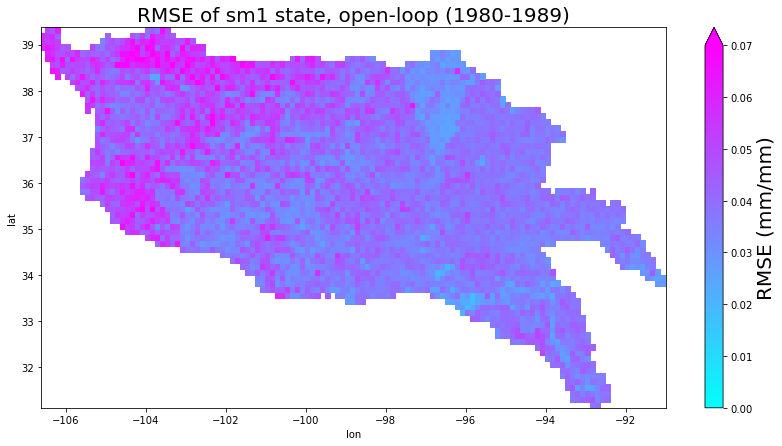

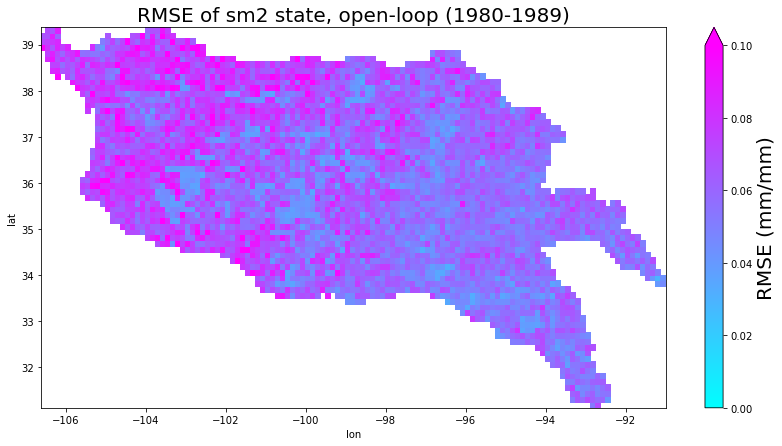

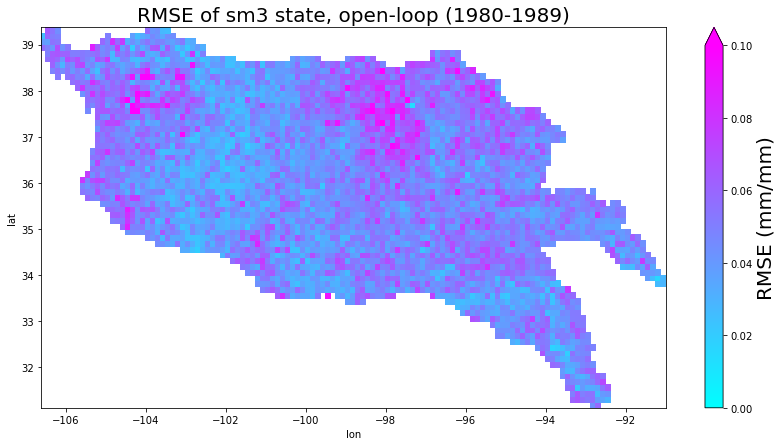

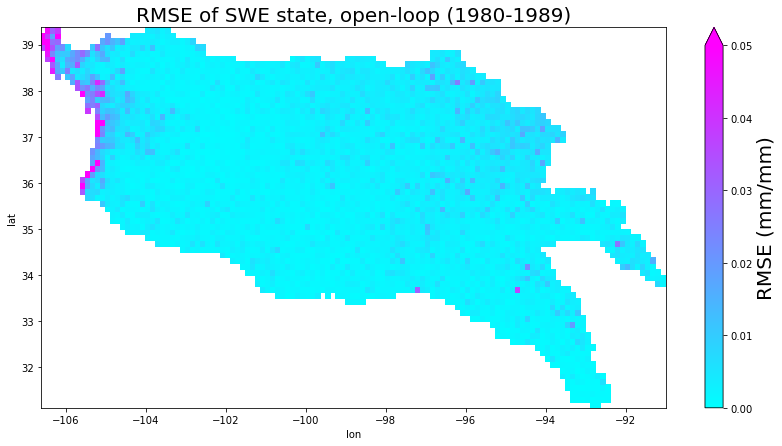

In [24]:
# ======================================================== #
# Plot maps
# ======================================================== #
# --- RMSE(sm1_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_sm1.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.07)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm1 state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.sm1.png'), format='png')

# --- RMSE(sm2_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_sm2.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm2 state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.sm2.png'), format='png')

# --- RMSE(sm3_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_sm3.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm3 state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.sm3.png'), format='png')

# --- RMSE(swe_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_swe.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.05)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of SWE state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.swe.png'), format='png')

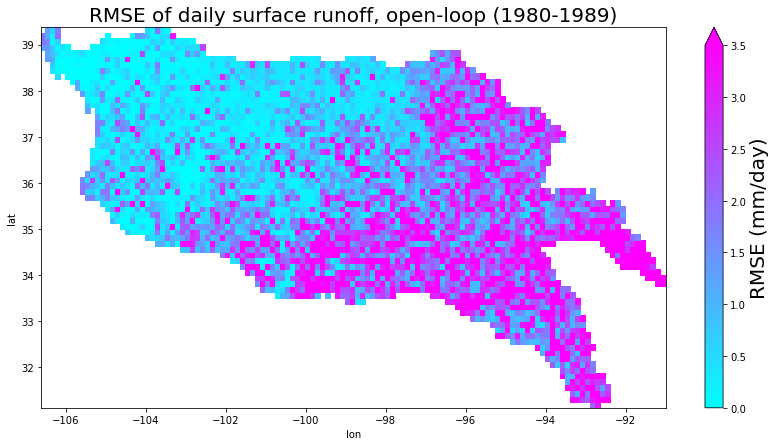

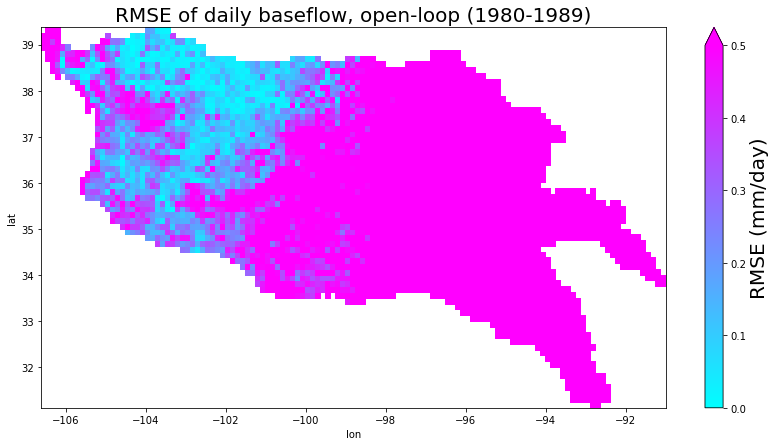

In [25]:
# --- RMSE(runoff_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_dailyRunoff.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=3.5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of daily surface runoff, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmse.openloop.dailyRunoff.png'), format='png')

# --- RMSE(baseflow_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_dailyBaseflow.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of daily baseflow, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmse.openloop.dailyBaseflow.png'), format='png')

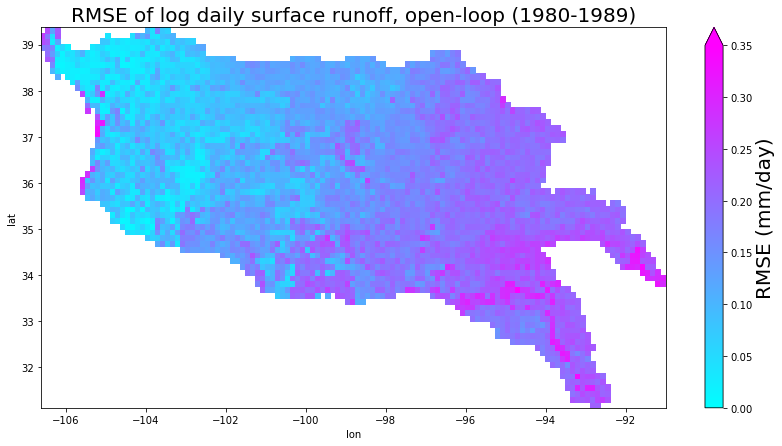

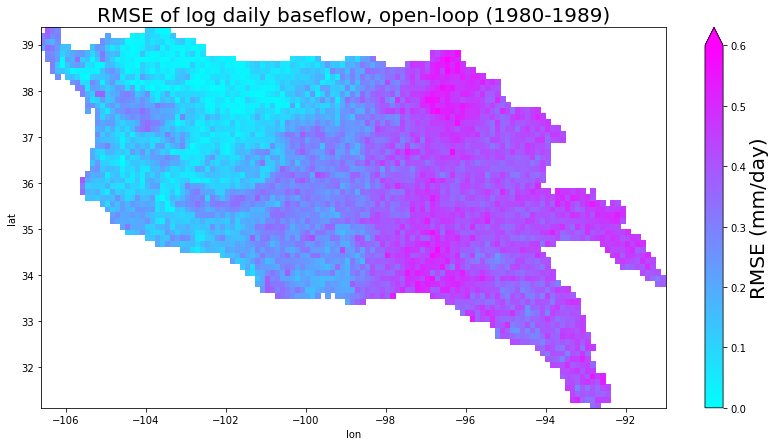

In [26]:
# --- RMSE_log(runoff_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_openloop_dailyRunoff.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.35)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of log daily surface runoff, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmseLog.openloop.dailyRunoff.png'), format='png')

# --- RMSE_log(baseflow_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_openloop_dailyBaseflow.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.6)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of log daily baseflow, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmseLog.openloop.dailyBaseflow.png'), format='png')

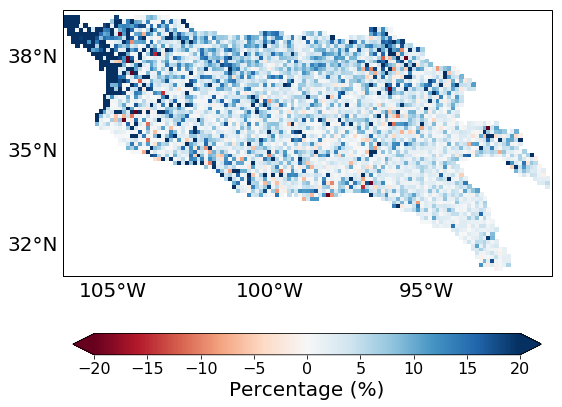

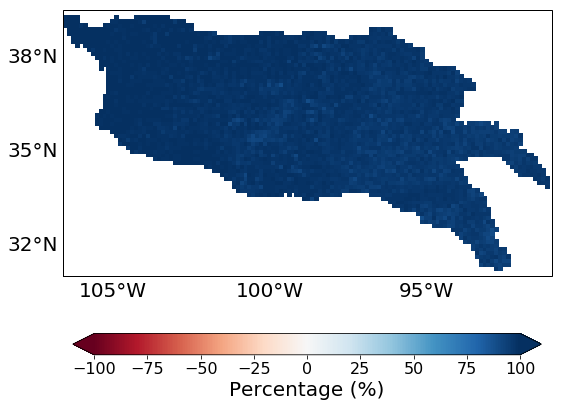

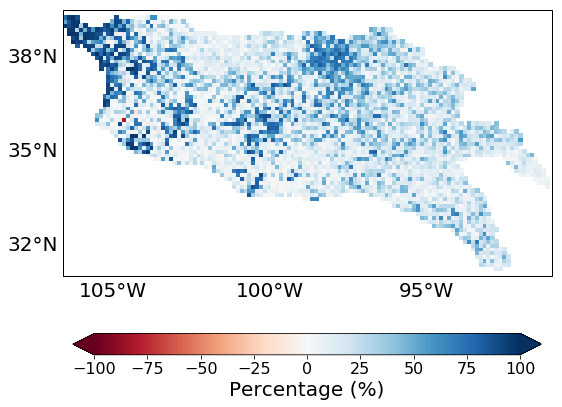

In [27]:
# ------------------------------------------ #
# --- Generate colorbars for PIMPROV --- #
# ------------------------------------------ #
# --- surface runoff --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmse.dailyRunoff.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

# --- baseflow --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmse.dailyBaseflow.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

# --- Total runoff --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmse.dailyTotrunoff.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

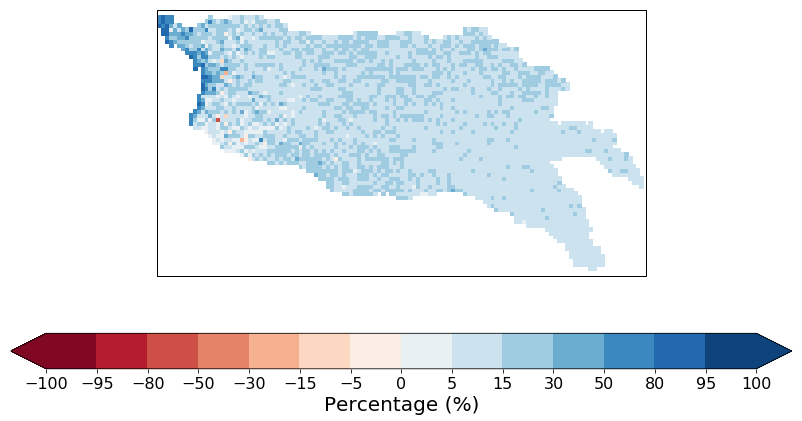

In [28]:
# ------------------------------------------ #
# --- Generate colorbars for PIMPROV_log --- #
# ------------------------------------------ #
def cmap_PIMPROV_listed(vmin=-100, vmax=100):
    '''listed PIMPROV colormap'''

    # Set colormap
    cmap_orig = matplotlib.cm.get_cmap('RdBu')
    
    # Set bounds
    bounds = np.array([-100, -95, -80, -50, -30, -15, -5, 
                       0, 5, 15, 30, 50, 80, 95, 100], np.float)
    n_intervals = len(bounds) - 1
    interval = 1.0 / n_intervals
    perc_array = np.arange(interval/2, 1, interval)
    red = cmap_orig(perc_array)[:, 0]
    green = cmap_orig(perc_array)[:, 1]
    blue = cmap_orig(perc_array)[:, 2]

    ticks = bounds
    colors = np.transpose(np.array([red, green, blue]))
#    bounds = (vmax - vmin) / (bounds.max()-bounds.min()) * bounds + vmin
    norm = matplotlib.colors.BoundaryNorm(bounds, colors.shape[0])
    cmap = matplotlib.colors.ListedColormap(colors)
#    cmap.set_bad('lightgray')
    return cmap, norm, ticks, colors

cmap, norm, ticks, colors = cmap_PIMPROV_listed()

fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyRunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', ticks=ticks, orientation='horizontal')
cbar.set_label('Percentage (%)', fontsize=20)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmseLog.dailyRunoff.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

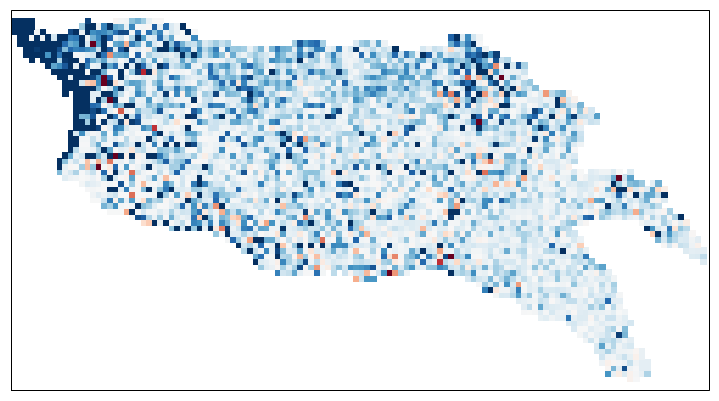

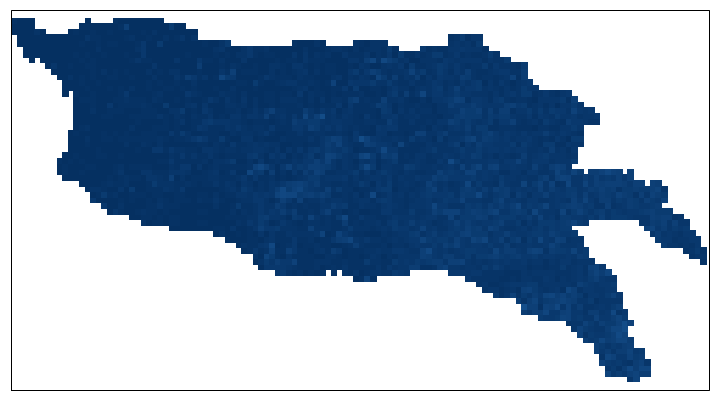

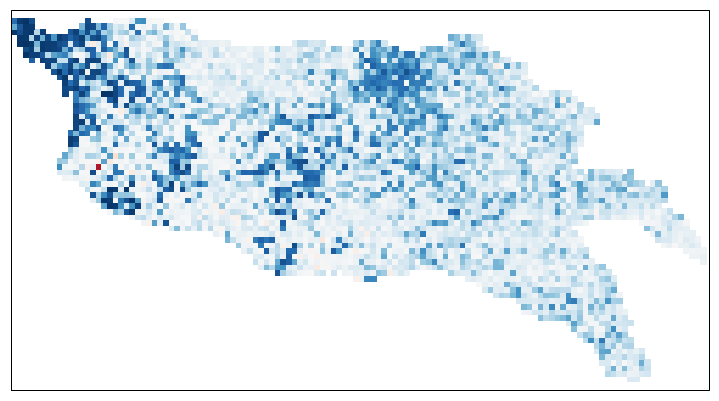

In [29]:
# --- PIMPROV(runoff_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthStateOrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthStateOrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthStateOrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

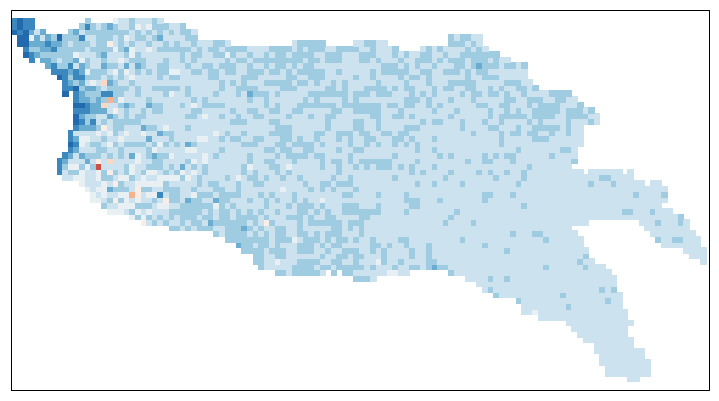

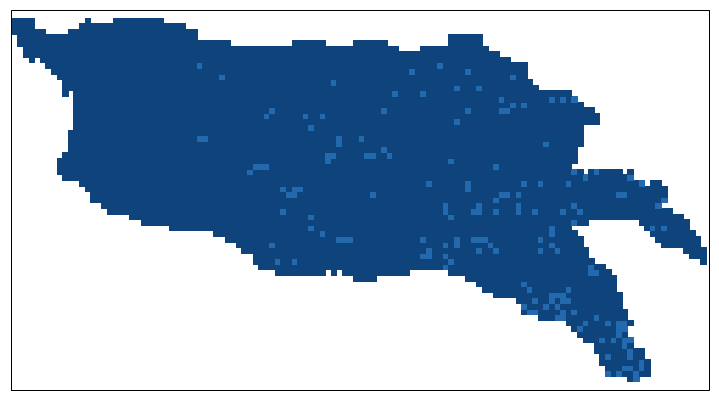

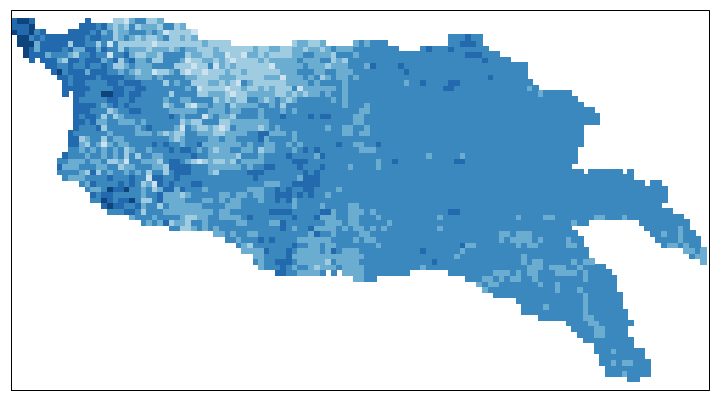

In [30]:
# --- PIMPROV(runoff_truthStateOrigP, RMSE_log) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyRunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthStateOrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyBaseflow_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthStateOrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyTotrunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
plt.title("")
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthStateOrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

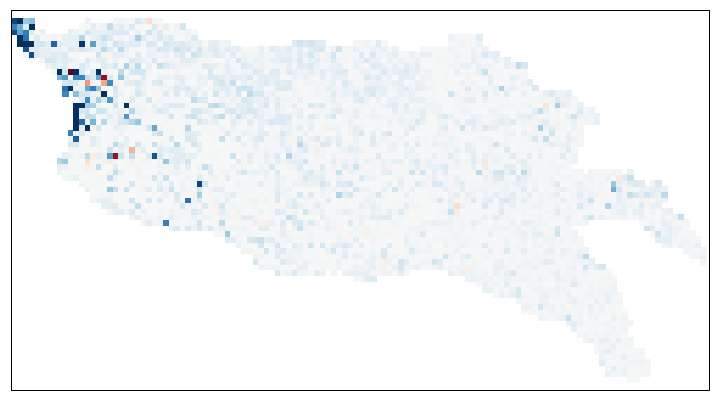

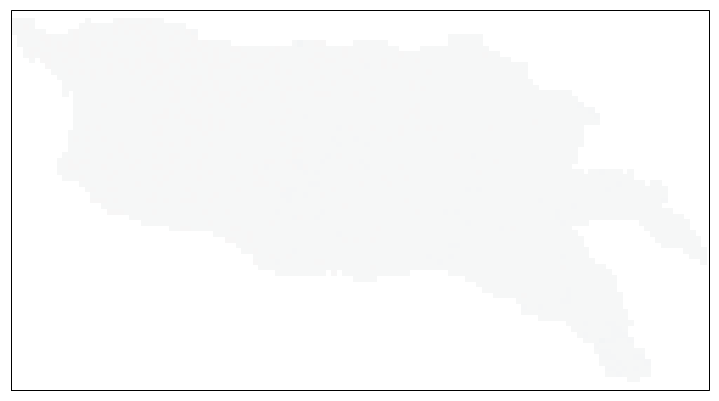

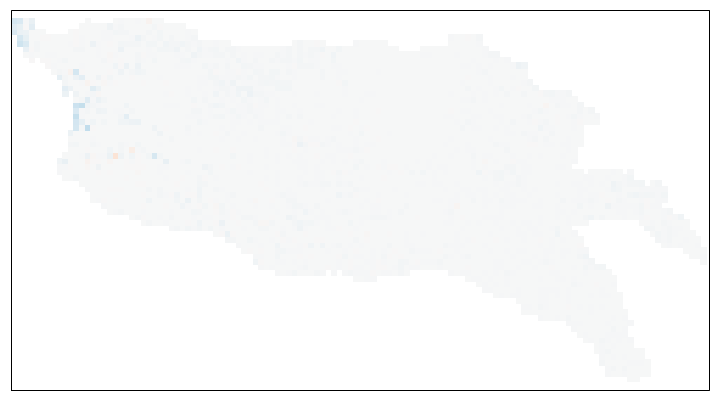

In [31]:
# --- PIMPROV(runoff_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM1OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM1OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM1OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

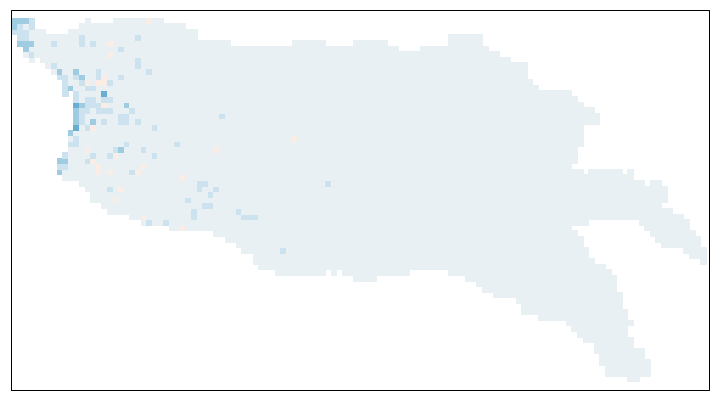

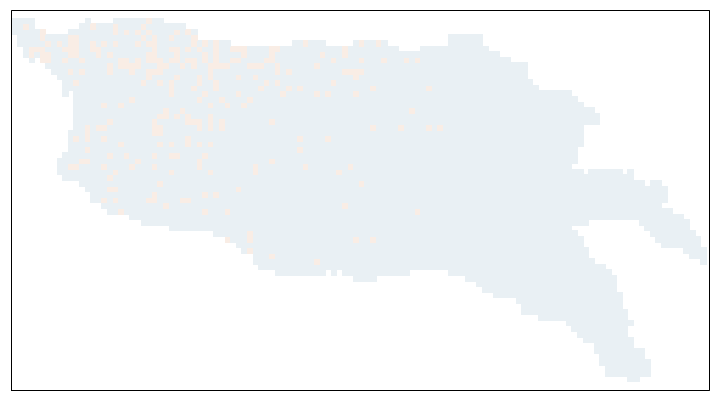

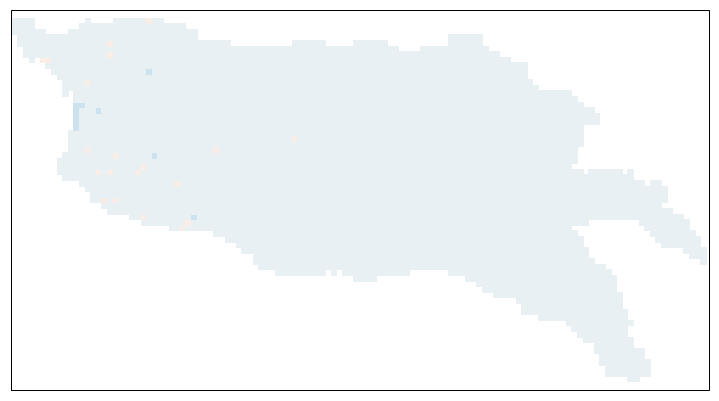

In [29]:
# --- PIMPROV(runoff_truthSM1OrigP, RMSE_log) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyRunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM1OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyBaseflow_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM1OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyTotrunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
plt.title("")
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM1OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

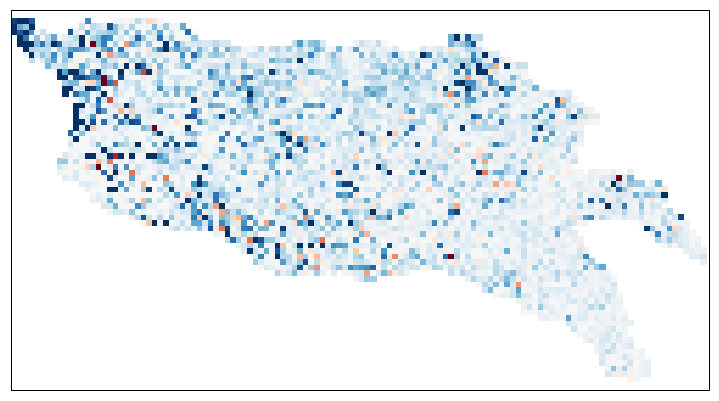

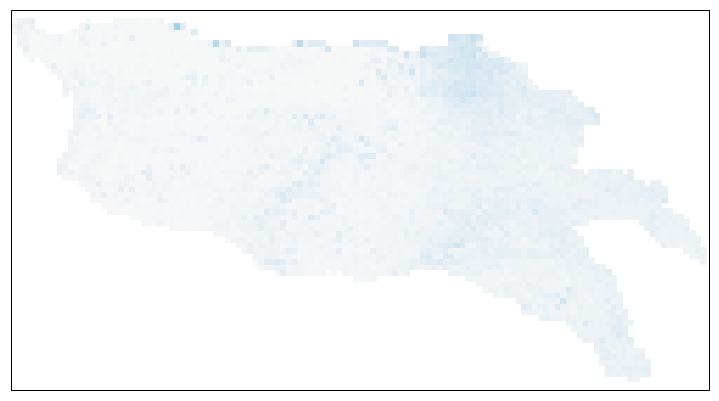

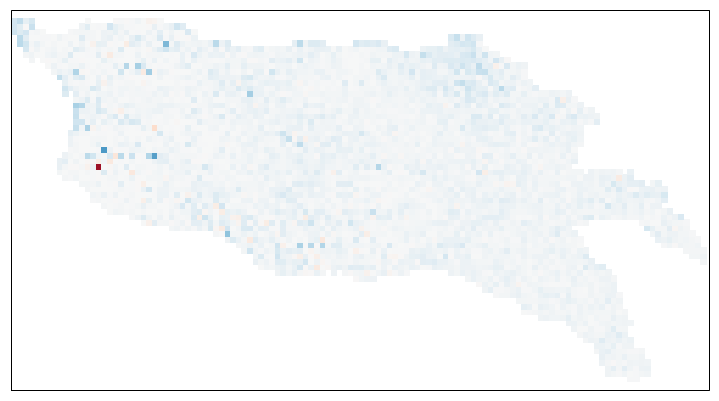

In [33]:
# --- PIMPROV(runoff_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM2OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM2OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM2OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

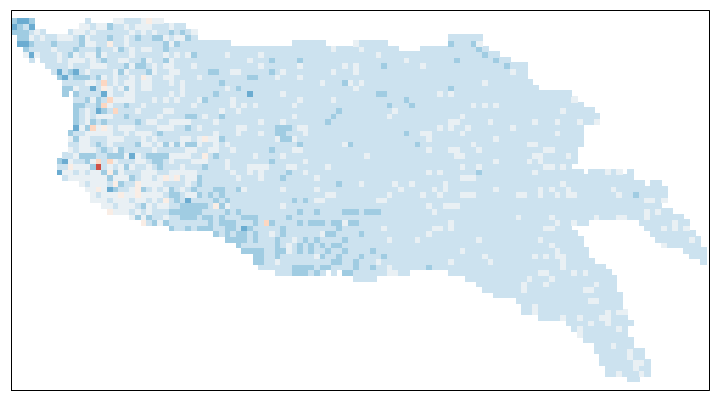

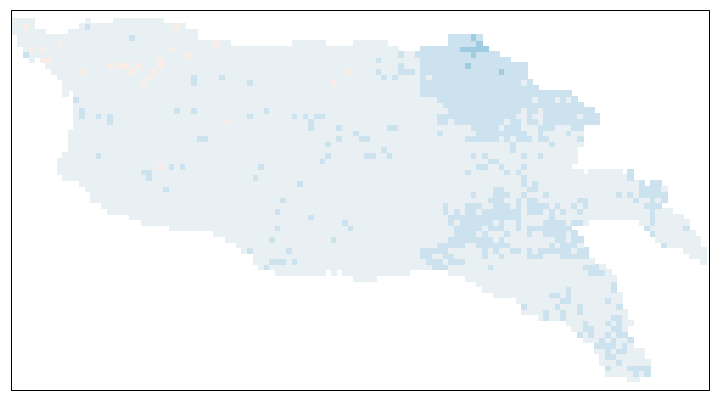

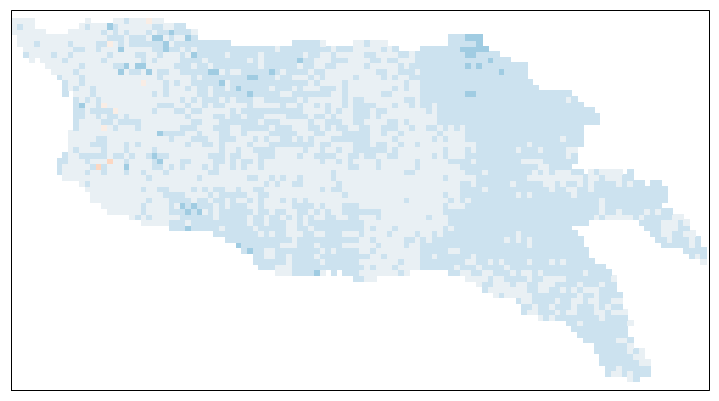

In [30]:
# --- PIMPROV(runoff_truthSM2OrigP, RMSE_log) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyRunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM2OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyBaseflow_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM2OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyTotrunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
plt.title("")
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM2OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

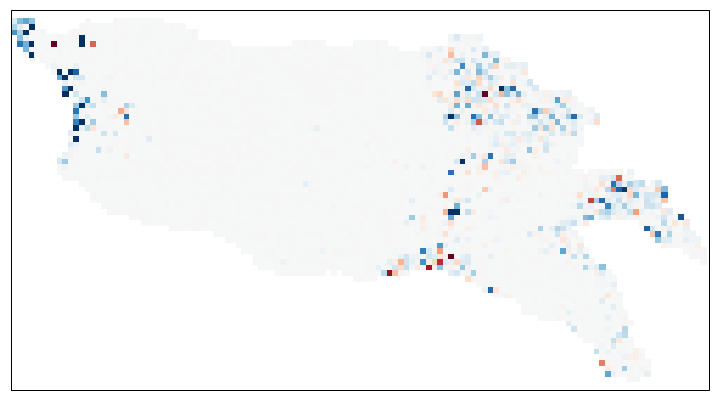

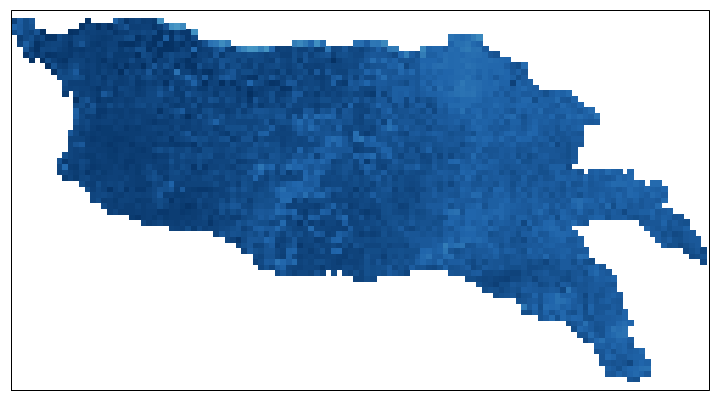

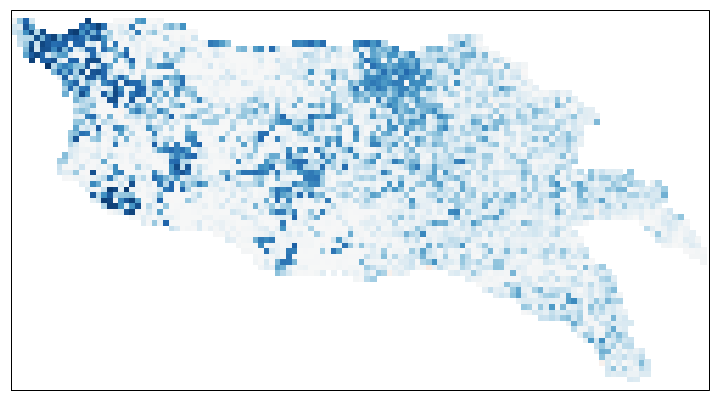

In [35]:
# --- PIMPROV(runoff_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM3OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM3OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM3OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

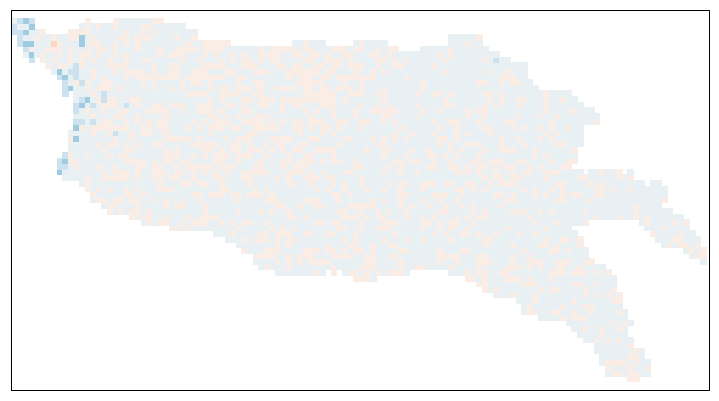

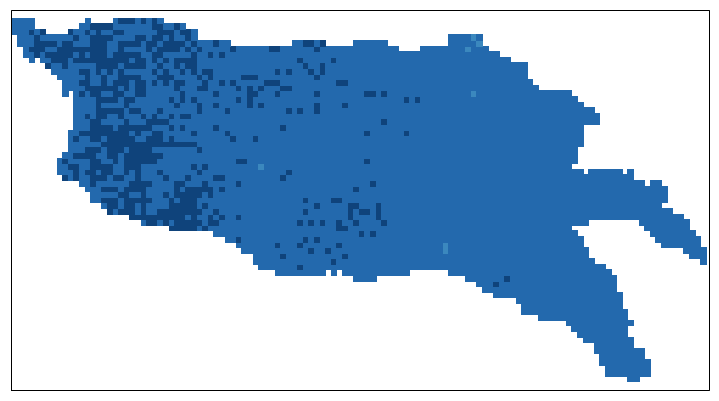

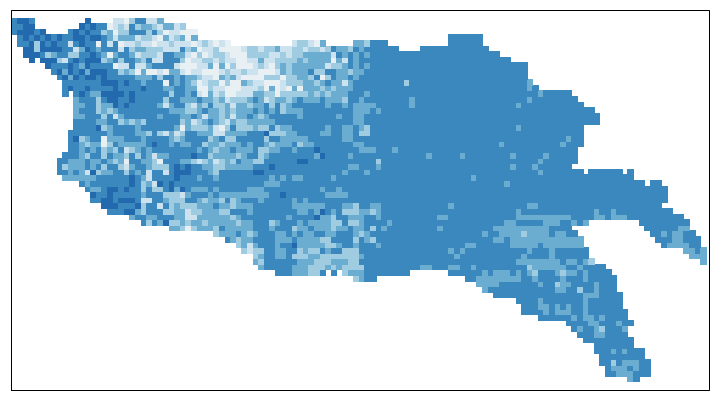

In [31]:
# --- PIMPROV(runoff_truthSM3OrigP, RMSE_log) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyRunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM3OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyBaseflow_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM3OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyTotrunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
plt.title("")
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSM3OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

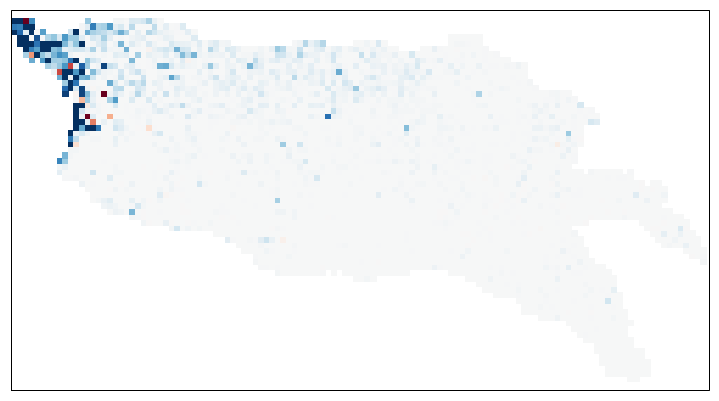

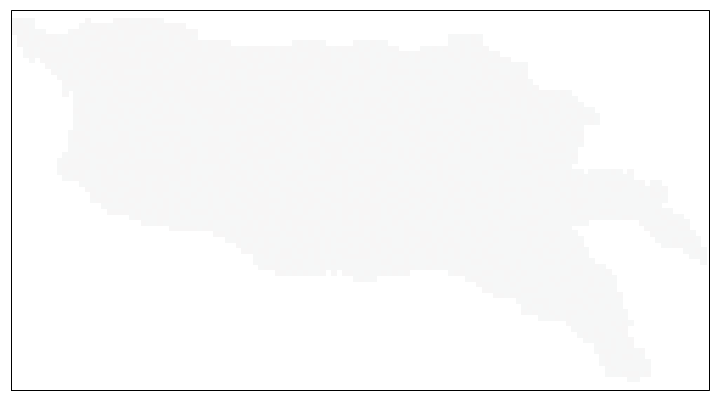

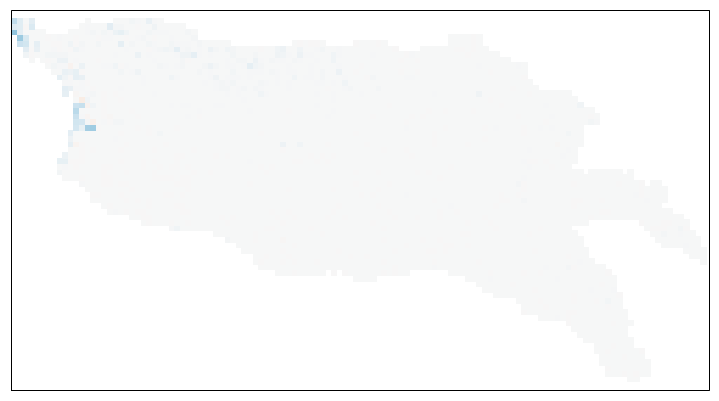

In [37]:
# --- PIMPROV(runoff_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSWEOrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSWEOrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSWEOrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

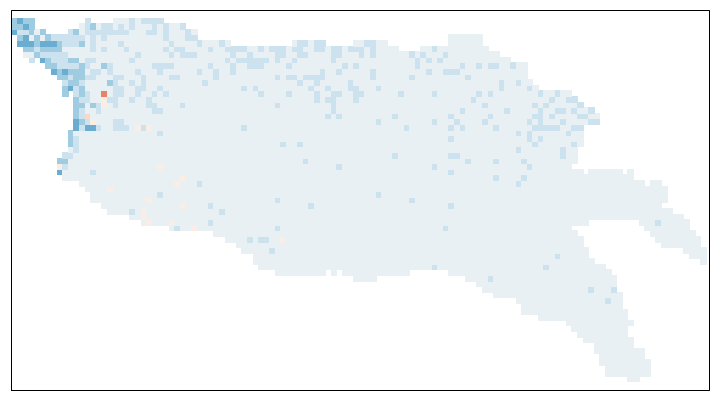

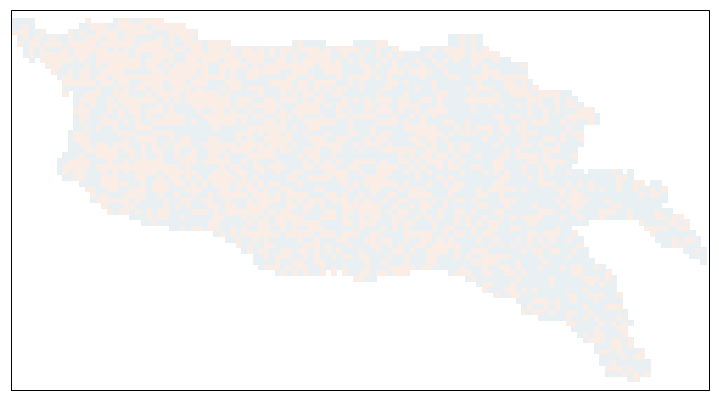

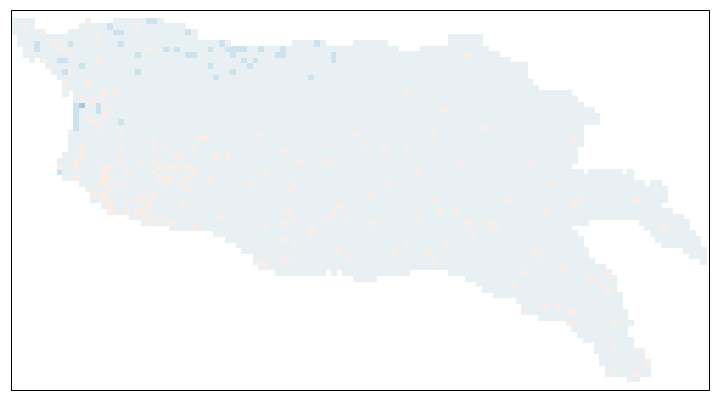

In [32]:
# --- PIMPROV(runoff_truthSWEOrigP, RMSE_log) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyRunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSWEOrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyBaseflow_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSWEOrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyTotrunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both', ticks=ticks) #  , orientation='horizontal')
#cbar.set_label('Percentage (%)', fontsize=20)
#for t in cbar.ax.get_xticklabels():
#    t.set_fontsize(16)
plt.title("")
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.truthSWEOrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Other plots

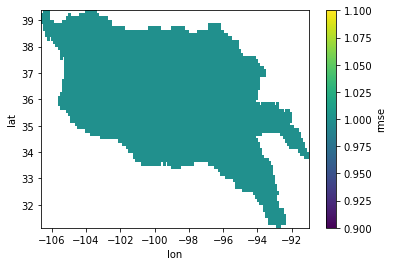

In [81]:
da_ArkRed_mask = pimprov_truthSWEOrigP_dailyRunoff_rmseLog.copy()
mask = da_ArkRed_mask.values
mask[~np.isnan(mask)] = 1
da_ArkRed_mask[:] = mask
da_ArkRed_mask.plot()

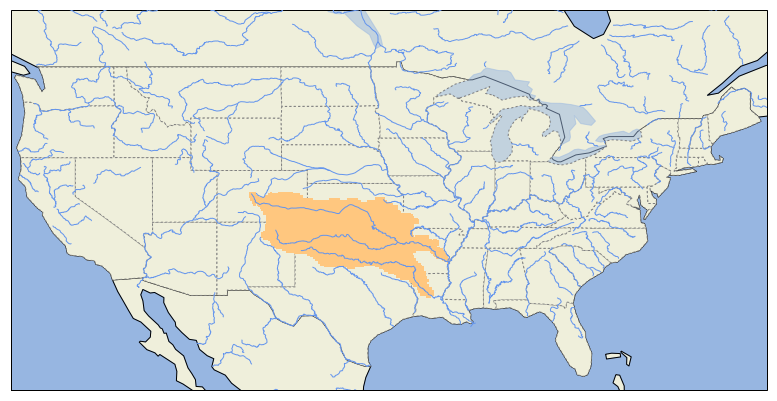

In [140]:
import cartopy
import cartopy.io.shapereader as shpreader

# ======================================================== #
# ArkRed map
# ======================================================== #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -66.5, 24, 50], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
# Add states
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor=[0.9375, 0.9375, 0.859375]
    edgecolor='grey'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linestyle=':')
# Add rivers
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='cornflowerblue')
ax.add_feature(rivers, zorder=3)
# Plot
cs = da_ArkRed_mask.plot.pcolormesh(
    'lon', 'lat', axes=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='copper',
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree(),
    zorder=2)
fig.savefig(os.path.join(output_maps_dir,
                         'ArkRed_map.png'),
            format='png', bbox_inches='tight', pad_inches=0)

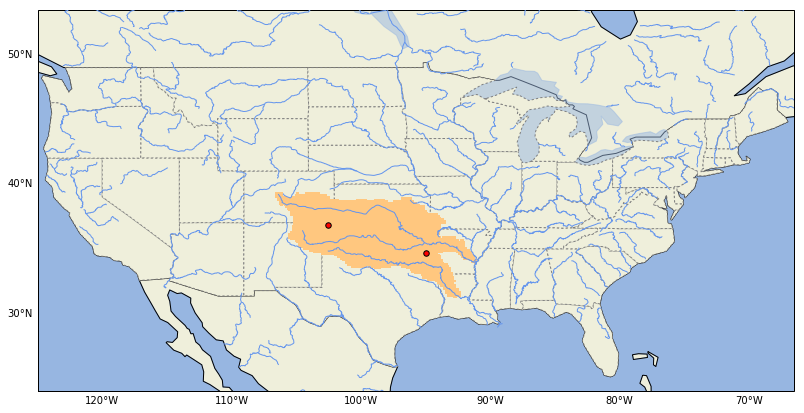

In [139]:
# --- ArkRed map with grid cells labeled out --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -66.5, 24, 50], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-120, -110, -100, -90, -80, -70],
                   ylocs=[30, 40, 50], alpha=0)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
# Add states
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor=[0.9375, 0.9375, 0.859375]
    edgecolor='grey'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linestyle=':')
# Add rivers
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='cornflowerblue')
ax.add_feature(rivers, zorder=3)
# Plot basin
cs = da_ArkRed_mask.plot.pcolormesh(
    'lon', 'lat', axes=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='copper',
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree(),
    zorder=2)
# Plot grid cells
ax.scatter(-94.9375, 34.6875, s=30, c='red', marker='o', edgecolor='k',
           transform=ccrs.PlateCarree(), zorder=4)
ax.scatter(-102.5625, 36.8125, s=30, c='red', marker='o', edgecolor='k',
           transform=ccrs.PlateCarree(), zorder=4)
fig.savefig(os.path.join(output_maps_dir,
                         'ArkRed_map.with_gridcells.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# ======================================================== #
# Plot snow maps
# ======================================================== #

da_swe_daily = ds_openloop_hist['OUT_SWE'].resample('1D', dim='time', how='mean')

In [ ]:
swe_cmap = plt.get_cmap('Blues')
swe_cmap.set_under(color='LightGrey')

# --- Maximum SWE value --- #
da_swe_max = da_swe_daily.max(dim='time')

fig = plt.figure(figsize=(14, 7))
cs = da_swe_max.where(da_domain==1).plot(
    add_colorbar=False, cmap=swe_cmap,
    vmin=10, vmax=100)
cbar = plt.colorbar(cs, extend='max').set_label('SWE (mm)', fontsize=20)
plt.title('Maximum SWE during 1980-1989 (based on open-loop)' \
          '\n(grid cells under 10 mm masked)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'snow_maps.max_swe.png'), format='png')

In [ ]:
# --- Apr SWE --- #
# extract monthly data for April only\n",
for group, content in da_swe_daily.groupby('time.month'):
    if group == 4:
        da_swe_Apr = content
        break
    else:
        continue
da_swe_Apr_mean = da_swe_Apr.mean(dim='time')
        
fig = plt.figure(figsize=(14, 7))
cs = da_swe_Apr_mean.where(da_domain==1).plot(
    add_colorbar=False, cmap=swe_cmap,
    vmin=10, vmax=100)
cbar = plt.colorbar(cs, extend='max').set_label('SWE (mm)', fontsize=20)
plt.title('April-mean SWE during 1980-1989 (based on open-loop)' \
          '\n(grid cells under 10 mm masked)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'snow_maps.Apr_swe.png'), format='png')

In [ ]:
# --- Number of days with SWE (>10mm) --- #
nyear = end_time.year - start_time.year + 1
da_snow_days_annual = (da_swe_daily>10).sum(dim='time') / nyear

fig = plt.figure(figsize=(14, 7))
cs = da_snow_days_annual.where(da_domain==1).plot(
    add_colorbar=False, cmap='Spectral',
    vmin=0, vmax=60)
cbar = plt.colorbar(cs, extend='max').set_label('Number of days', fontsize=20)
plt.title('Annual number of days with SWE>10mm during 1980-1989 (based on open-loop)',
          fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'snow_maps.snow_days.png'), format='png')

In [ ]:
# --- snow_melt / surface_runoff --- #
da_snowmelt_mean = ds_openloop_hist['OUT_SNOW_MELT'].mean(dim='time')
da_runoff_mean = ds_openloop_hist['OUT_RUNOFF'].mean(dim='time')

In [ ]:
ds_openloop_hist['OUT_SNOW_MELT'][:, 30, 30].plot(color='orange')
ds_openloop_hist['OUT_RUNOFF'][:, 30, 30].plot(color='blue')

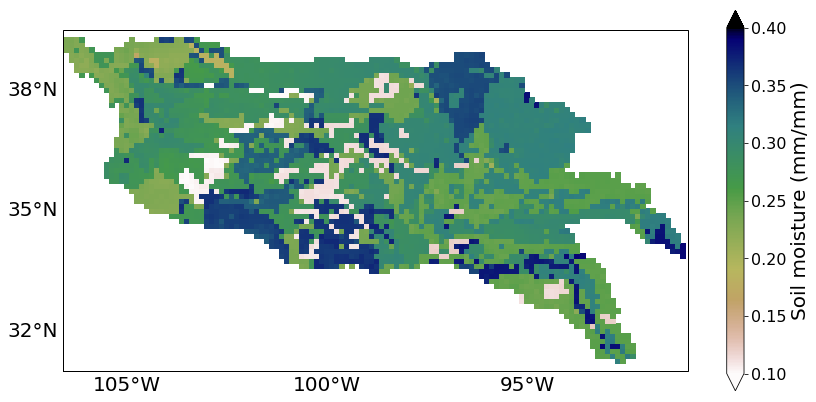

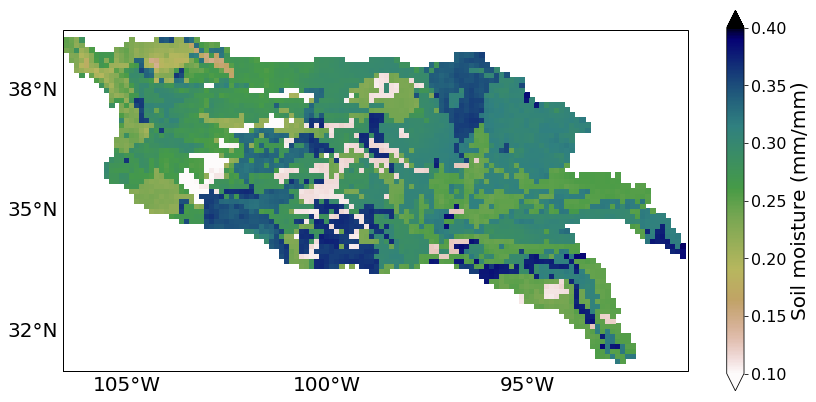

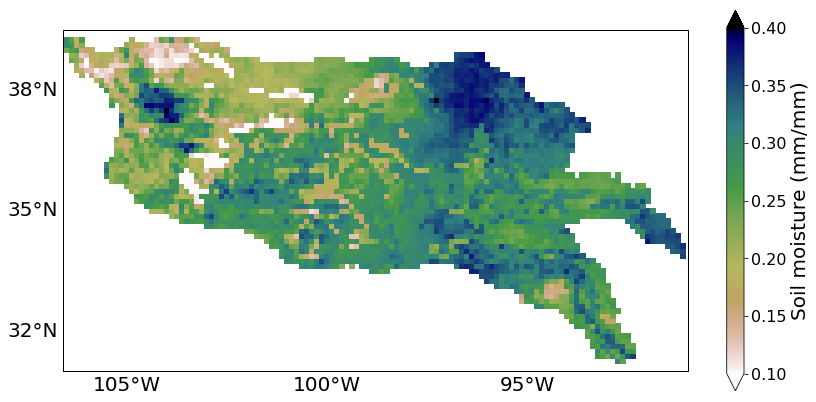

In [33]:
# --- Open-loop states --- #
# --- sm1 --- #
da_sm1_mean = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=0).mean(dim='time') / depth_sm1
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_sm1_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='gist_earth_r',
    vmin=0.1, vmax=0.4,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture (mm/mm)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'sm1.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm2 --- #
da_sm2_mean = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=1).mean(dim='time') / depth_sm2
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_sm2_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='gist_earth_r',
    vmin=0.1, vmax=0.4,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture (mm/mm)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'sm2.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm3 --- #
da_sm3_mean = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=2).mean(dim='time') / depth_sm3
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_sm3_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='gist_earth_r',
    vmin=0.1, vmax=0.4,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture (mm/mm)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'sm3.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

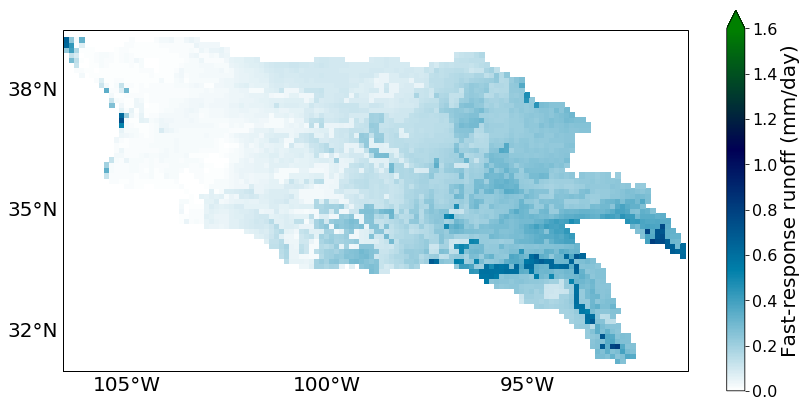

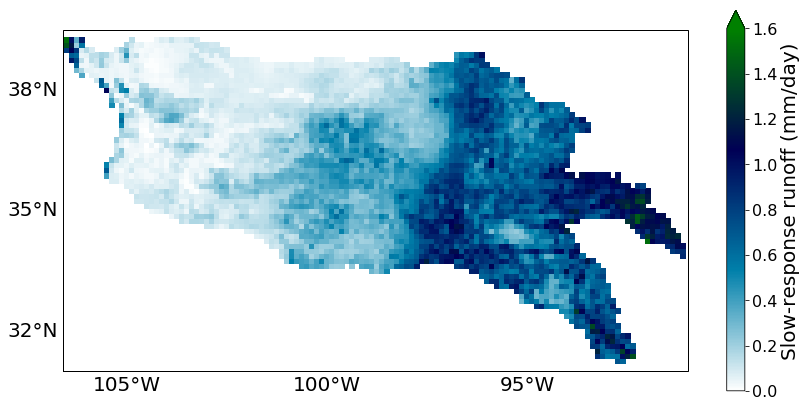

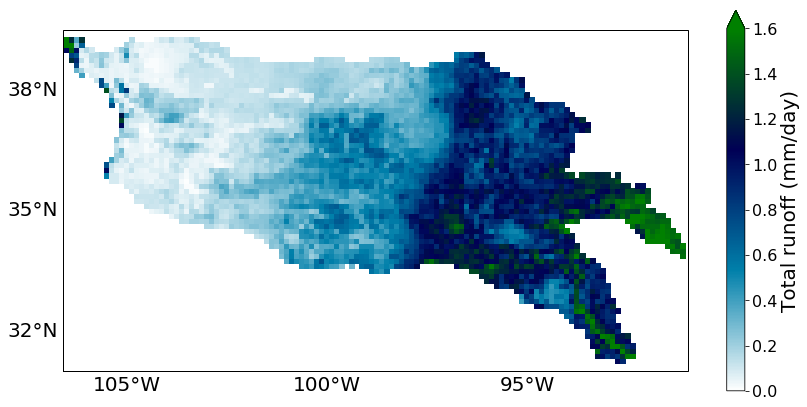

In [35]:
# --- Surface runoff --- #
out_nc = os.path.join(output_data_dir, 'openloop_dailyRunoff_mean.nc')
if not os.path.isfile(out_nc):
    da_dailyRunoff_mean = ds_openloop_hist['OUT_RUNOFF'].resample(
        '1D', dim='time', how='sum').mean(dim='time')
    ds_dailyRunoff_mean = xr.Dataset(
            {'runoff': da_dailyRunoff_mean})
    ds_dailyRunoff_mean.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    da_dailyRunoff_mean = xr.open_dataset(out_nc)['runoff']
    
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_dailyRunoff_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='ocean_r',
    vmin=0, vmax=1.6,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max')
cbar.set_label('Fast-response runoff (mm/day)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'runoff.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- Baseflow --- #
out_nc = os.path.join(output_data_dir, 'openloop_dailyBaseflow_mean.nc')
if not os.path.isfile(out_nc):
    da_dailyBaseflow_mean = ds_openloop_hist['OUT_BASEFLOW'].resample(
        '1D', dim='time', how='sum').mean(dim='time')
    ds_dailyBaseflow_mean = xr.Dataset(
            {'baseflow': da_dailyBaseflow_mean})
    ds_dailyBaseflow_mean.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    da_dailyBaseflow_mean = xr.open_dataset(out_nc)['baseflow']
    
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_dailyBaseflow_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='ocean_r',
    vmin=0, vmax=1.6,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max')
cbar.set_label('Slow-response runoff (mm/day)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'baseflow.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- Total runoff --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = (da_dailyRunoff_mean + da_dailyBaseflow_mean).where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='ocean_r',
    vmin=0, vmax=1.6,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max')
cbar.set_label('Total runoff (mm/day)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'totrunoff.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


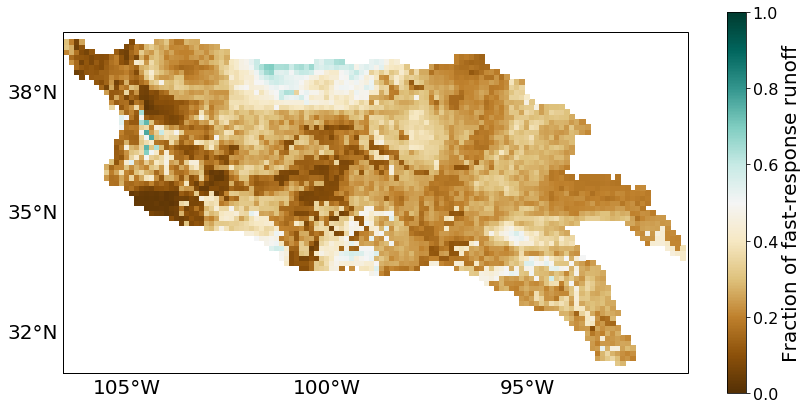

In [36]:
# --- Surface runoff fraction --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = (da_dailyRunoff_mean / (da_dailyRunoff_mean + da_dailyBaseflow_mean)).where(
    da_domain==1).plot.pcolormesh(
        'lon', 'lat', ax=ax,
        add_colorbar=False,
        add_labels=False,
        cmap='BrBG',
        vmin=0, vmax=1,
        transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)
cbar.set_label('Fraction of fast-response runoff', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'runoff_frac.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [44]:
# ======================================================== #
# Plot time series
# ======================================================== #
# === 31.1875, -92.6875 === #
lat = 34.9375
lon = -96.6875

# # --- sm1 --- #
# output_file(os.path.join(output_ts_dir, '{}_{}.sm1.html'.format(lat, lon)))
# p = figure(title='SM1, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # plot measurement
# ts = da_meas.sel(lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.circle(ts.index, ts.values, color="red", fill_color="red",
#          legend="Measurement", line_width=2)
# # Save
# save(p)

# # --- sm2 --- #
# fig = plt.figure(figsize=(12, 6))
# # plot open-loop
# ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# ts_openloop.plot(color='m', style='-',
#                  label='Open-loop',
#                  legend=True)
# # plot truth
# ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# ts_truth.plot(color='k', style='-',
#               label='Truth',
#               legend=True)
# # Make plot looks better
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Soil moiture (mm/mm)', fontsize=16)
# plt.title('SM2, {}, {}'.format(lat, lon), fontsize=16)
# # Save figure
# fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm2.png'.format(lat, lon)),
#             format='png')
# ### Interactive plot ###
# output_file(os.path.join(output_ts_dir, '{}_{}.sm2.html'.format(lat, lon)))
# p = figure(title='SM2, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # plot measurement
# ts = da_meas.sel(lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.circle(ts.index, ts.values, color="red", fill_color="red",
#          legend="Measurement", line_width=2)
# # Save
# save(p)

# # --- sm3 --- #
# fig = plt.figure(figsize=(12, 6))
# # plot open-loop
# ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# ts_openloop.plot(color='m', style='-',
#                  label='Open-loop',
#                  legend=True)
# # plot truth
# ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# ts_truth.plot(color='k', style='-',
#               label='Truth',
#               legend=True)
# # Make plot looks better
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Soil moiture (mm/mm)', fontsize=16)
# plt.title('SM3, {}, {}'.format(lat, lon), fontsize=16)
# # Save figure
# fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm3.png'.format(lat, lon)),
#             format='png')
# ### Interactive plot ###
# output_file(os.path.join(output_ts_dir, '{}_{}.sm3.html'.format(lat, lon)))
# p = figure(title='SM3, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

# # --- Surface runoff --- #
# output_file(os.path.join(output_ts_dir, '{}_{}.runoff.html'.format(lat, lon)))
# p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Runoff (mm/day)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
#         '1D', dim='time', how='sum').to_series()
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
#         '1D', dim='time', how='sum').to_series()
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

# # --- Baseflow --- #
# fig = plt.figure(figsize=(12, 6))
# # plot open-loop
# ts_openloop = ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
#     '1D', dim='time', how='sum').to_series()
# ts_openloop.plot(color='m', style='-',
#                  label='Open-loop',
#                  legend=True)
# # plot truth
# ts_truth = ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
#     '1D', dim='time', how='sum').to_series()
# ts_truth.plot(color='k', style='-',
#               label='Truth',
#               legend=True)
# # Make plot looks better
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Baseflow (mm/day)', fontsize=16)
# plt.title('Baseflow, {}, {}'.format(lat, lon), fontsize=16)
# # Save figure
# fig.savefig(os.path.join(output_ts_dir, '{}_{}.baseflow.png'.format(lat, lon)),
#             format='png')
# ### Interactive ###
# output_file(os.path.join(output_ts_dir, '{}_{}.baseflow.html'.format(lat, lon)))
# p = figure(title='Baseflow, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ts_openloop
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ts_truth
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

In [45]:
# --- Surface runoff, perfect-all-state --- #
ts_truthStateOrigP_dailyRunoff = ds_truthStateOrigP_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).resample('1D', dim='time', how='sum').to_series()
output_file(os.path.join(output_ts_dir, '{}_{}.runoff_truthState.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# plot perfect-all-state
ts = ts_truthStateOrigP_dailyRunoff
p.line(ts.index, ts.values, color="blue", line_dash="dashed",
       legend="Perfect-all-state", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20170611.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param.synthetic/time_series/34.9375_-96.6875.runoff_truthState.html'

In [ ]:
# --- Baseflow, perfect-all-state --- #
ts_truthStateOrigP_dailyBaseflow = ds_truthStateOrigP_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).resample('1D', dim='time', how='sum').to_series()
output_file(os.path.join(output_ts_dir, '{}_{}.baseflow_truthState.html'.format(lat, lon)))
p = figure(title='Baseflow, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# plot perfect-all-state
ts = ts_truthStateOrigP_dailyBaseflow
p.line(ts.index, ts.values, color="blue", line_dash="dashed",
       legend="Perfect-all-state", line_width=2)
# Save
save(p)

In [ ]:
# --- Total runoff, perfect-all-state --- #
ts_truthStateOrigP_dailyTotrunoff = \
    (ds_truthStateOrigP_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon) + \
     ds_truthStateOrigP_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon)).resample(
        '1D', dim='time', how='sum').to_series()
output_file(os.path.join(output_ts_dir, '{}_{}.totrunoff_truthState.html'.format(lat, lon)))
p = figure(title='Total runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = (ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon) + \
      ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon)).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = (ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon) + \
      ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon)).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# plot perfect-all-state
ts = ts_truthStateOrigP_dailyTotrunoff
p.line(ts.index, ts.values, color="blue", line_dash="dashed",
       legend="Perfect-all-state", line_width=2)
# Save
save(p)

In [ ]:
# --- Precipitation forcing time series --- #
# --- Load data ---- #
# open-loop
start_year = start_time.year
end_year = end_time.year
list_ts_prec = []
for year in range(start_year, end_year+1):
    force_nc = '{}{}.nc'.format(orig_force_basepath, year)
    ts_prec = xr.open_dataset(force_nc)['PREC'].sel(lat=lat, lon=lon).to_series()
    list_ts_prec.append(ts_prec)
ts_openloop_prec = pd.concat(list_ts_prec, axis=0)

# truth
start_year = start_time.year
end_year = end_time.year
list_ts_prec = []
for year in range(start_year, end_year+1):
    force_nc = '{}{}.nc'.format(truth_force_basepath, year)
    ts_prec = xr.open_dataset(force_nc)['PREC'].sel(lat=lat, lon=lon).to_series()
    list_ts_prec.append(ts_prec)
ts_truth_prec = pd.concat(list_ts_prec, axis=0)

In [ ]:
# --- plot --- #
output_file(os.path.join(output_ts_dir, '{}_{}.prec_daily.html'.format(lat, lon)))
p = figure(title='Precipitation, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Precipitation (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ts_openloop_prec.resample('D', how='sum')
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ts_truth_prec.resample('D', how='sum')
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

In [ ]:
np.log(ds_openloop_hist['OUT_RUNOFF'].resample(
    '1D', dim='time', how='sum')+1)

# Other

In [ ]:
lat = 35.0625
lon = -96.6875

In [ ]:
# --- Extract time series --- #
# truthStateOrigP
ts_truthStateOrigP_dailyRunoff = ds_truthStateOrigP_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).resample('1D', dim='time', how='sum').to_series()
ts_truthStateOrigP_dailyBaseflow = ds_truthStateOrigP_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).resample('1D', dim='time', how='sum').to_series()
ts_truthStateOrigP_dailyTotrunoff = ts_truthStateOrigP_dailyRunoff + ts_truthStateOrigP_dailyBaseflow

In [ ]:
# Openloop
ts_openloop_dailyRunoff = ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
ts_openloop_dailyBaseflow = ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
ts_openloop_dailyTotrunoff = ts_openloop_dailyRunoff + ts_openloop_dailyBaseflow

In [ ]:
# Truth
ts_truth_dailyRunoff = ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
ts_truth_dailyBaseflow = ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
ts_truth_dailyTotrunoff = ts_truth_dailyRunoff + ts_truth_dailyBaseflow

In [ ]:
import pickle
with open('tmp/{}_{}/ts_truthStateOrigP_dailyRunoff'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_truthStateOrigP_dailyRunoff, f)
with open('tmp/{}_{}/ts_truthStateOrigP_dailyBaseflow'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_truthStateOrigP_dailyBaseflow, f)
with open('tmp/{}_{}/ts_truthStateOrigP_dailyTotrunoff'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_truthStateOrigP_dailyTotrunoff, f)

with open('tmp/{}_{}/ts_truth_dailyRunoff'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_truth_dailyRunoff, f)
with open('tmp/{}_{}/ts_truth_dailyBaseflow'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_truth_dailyBaseflow, f)
with open('tmp/{}_{}/ts_truth_dailyTotrunoff'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_truth_dailyTotrunoff, f)
    
with open('tmp/{}_{}/ts_openloop_dailyRunoff'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_openloop_dailyRunoff, f)
with open('tmp/{}_{}/ts_openloop_dailyBaseflow'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_openloop_dailyBaseflow, f)
with open('tmp/{}_{}/ts_openloop_dailyTotrunoff'.format(lat, lon), 'wb') as f:
    pickle.dump(ts_openloop_dailyTotrunoff, f)

In [ ]:
import pickle
with open('tmp/{}_{}/ts_truthStateOrigP_dailyRunoff'.format(lat, lon), 'rb') as f:
    ts_truthStateOrigP_dailyRunoff = pickle.load(f)
with open('tmp/{}_{}/ts_truthStateOrigP_dailyBaseflow'.format(lat, lon), 'rb') as f:
    ts_truthStateOrigP_dailyBaseflow = pickle.load(f)
with open('tmp/{}_{}/ts_truthStateOrigP_dailyTotrunoff'.format(lat, lon), 'rb') as f:
    ts_truthStateOrigP_dailyTotrunoff = pickle.load(f)

with open('tmp/{}_{}/ts_truth_dailyRunoff'.format(lat, lon), 'rb') as f:
    ts_truth_dailyRunoff = pickle.load(f)
with open('tmp/{}_{}/ts_truth_dailyBaseflow'.format(lat, lon), 'rb') as f:
    ts_truth_dailyBaseflow = pickle.load(f)
with open('tmp/{}_{}/ts_truth_dailyTotrunoff'.format(lat, lon), 'rb') as f:
    ts_truth_dailyTotrunoff = pickle.load(f)
    
with open('tmp/{}_{}/ts_openloop_dailyRunoff'.format(lat, lon), 'rb') as f:
    ts_openloop_dailyRunoff = pickle.load(f)
with open('tmp/{}_{}/ts_openloop_dailyBaseflow'.format(lat, lon), 'rb') as f:
    ts_openloop_dailyBaseflow = pickle.load(f)
with open('tmp/{}_{}/ts_openloop_dailyTotrunoff'.format(lat, lon), 'rb') as f:
    ts_openloop_dailyTotrunoff = pickle.load(f)

In [ ]:
# --- Calculate RMSE --- #
# Surface runoff
rmse_openloop_dailyRunoff = rmse(ts_truth_dailyRunoff, ts_openloop_dailyRunoff)
rmse_truthStateOrigP_dailyRunoff = rmse(ts_truth_dailyRunoff, ts_truthStateOrigP_dailyRunoff)
pimprov_truthStateOrigP_dailyRunoff = (1 - rmse_truthStateOrigP_dailyRunoff/rmse_openloop_dailyRunoff) * 100
# Baseflow
rmse_openloop_dailyBaseflow = rmse(ts_truth_dailyBaseflow, ts_openloop_dailyBaseflow)
rmse_truthStateOrigP_dailyBaseflow = rmse(ts_truth_dailyBaseflow, ts_truthStateOrigP_dailyBaseflow)
pimprov_truthStateOrigP_dailyBaseflow = \
    (1 - rmse_truthStateOrigP_dailyBaseflow/rmse_openloop_dailyBaseflow) * 100
# Total runoff
rmse_openloop_dailyTotrunoff = rmse(ts_truth_dailyTotrunoff, ts_openloop_dailyTotrunoff)
rmse_truthStateOrigP_dailyTotrunoff = rmse(ts_truth_dailyTotrunoff, ts_truthStateOrigP_dailyTotrunoff)
pimprov_truthStateOrigP_dailyTotrunoff = \
    (1 - rmse_truthStateOrigP_dailyTotrunoff/rmse_openloop_dailyTotrunoff) * 100

In [ ]:
print(rmse_openloop_dailyTotrunoff, rmse_openloop_dailyRunoff, rmse_openloop_dailyBaseflow)
print(rmse_truthStateOrigP_dailyTotrunoff, rmse_truthStateOrigP_dailyRunoff, rmse_truthStateOrigP_dailyBaseflow)

In [ ]:
print(pimprov_truthStateOrigP_dailyTotrunoff, pimprov_truthStateOrigP_dailyRunoff,
      pimprov_truthStateOrigP_dailyBaseflow)

In [ ]:
ts_openloop_dailyRunoff.sum() / ts_openloop_dailyTotrunoff.sum()

In [ ]:
print(np.square(rmse_openloop_dailyRunoff))

In [ ]:
np.square((ts_openloop_dailyRunoff[1388] - ts_truth_dailyRunoff[1388])) / len(ts_openloop_dailyRunoff)

In [ ]:
# ===================================================== #
# Try dropping the very-high-surface-runoff day
# ===================================================== #
tsDrop_openloop_dailyTotrunoff = ts_openloop_dailyTotrunoff.drop(pd.to_datetime('1983-10-20'))
tsDrop_openloop_dailyRunoff = ts_openloop_dailyRunoff.drop(pd.to_datetime('1983-10-20'))
tsDrop_openloop_dailyBaseflow = ts_openloop_dailyBaseflow.drop(pd.to_datetime('1983-10-20'))

tsDrop_truth_dailyTotrunoff = ts_truth_dailyTotrunoff.drop(pd.to_datetime('1983-10-20'))
tsDrop_truth_dailyRunoff = ts_truth_dailyRunoff.drop(pd.to_datetime('1983-10-20'))
tsDrop_truth_dailyBaseflow = ts_truth_dailyBaseflow.drop(pd.to_datetime('1983-10-20'))

tsDrop_truthStateOrigP_dailyTotrunoff = ts_truthStateOrigP_dailyTotrunoff.drop(pd.to_datetime('1983-10-20'))
tsDrop_truthStateOrigP_dailyRunoff = ts_truthStateOrigP_dailyRunoff.drop(pd.to_datetime('1983-10-20'))
tsDrop_truthStateOrigP_dailyBaseflow = ts_truthStateOrigP_dailyBaseflow.drop(pd.to_datetime('1983-10-20'))

# --- Calculate RMSE --- #
# Surface runoff
rmseDrop_openloop_dailyRunoff = rmse(tsDrop_truth_dailyRunoff, tsDrop_openloop_dailyRunoff)
rmseDrop_truthStateOrigP_dailyRunoff = rmse(tsDrop_truth_dailyRunoff, tsDrop_truthStateOrigP_dailyRunoff)
pimprovDrop_truthStateOrigP_dailyRunoff = \
    (1 - rmseDrop_truthStateOrigP_dailyRunoff/rmseDrop_openloop_dailyRunoff) * 100
# Baseflow
rmseDrop_openloop_dailyBaseflow = rmse(tsDrop_truth_dailyBaseflow, tsDrop_openloop_dailyBaseflow)
rmseDrop_truthStateOrigP_dailyBaseflow = rmse(tsDrop_truth_dailyBaseflow, tsDrop_truthStateOrigP_dailyBaseflow)
pimprovDrop_truthStateOrigP_dailyBaseflow = \
    (1 - rmseDrop_truthStateOrigP_dailyBaseflow/rmseDrop_openloop_dailyBaseflow) * 100
# Total runoff
rmseDrop_openloop_dailyTotrunoff = rmse(tsDrop_truth_dailyTotrunoff, tsDrop_openloop_dailyTotrunoff)
rmseDrop_truthStateOrigP_dailyTotrunoff = rmse(tsDrop_truth_dailyTotrunoff, tsDrop_truthStateOrigP_dailyTotrunoff)
pimprovDrop_truthStateOrigP_dailyTotrunoff = \
    (1 - rmseDrop_truthStateOrigP_dailyTotrunoff/rmseDrop_openloop_dailyTotrunoff) * 100

In [ ]:
print(rmseDrop_openloop_dailyTotrunoff, rmseDrop_openloop_dailyRunoff, rmseDrop_openloop_dailyBaseflow)
print(rmseDrop_truthStateOrigP_dailyTotrunoff, rmseDrop_truthStateOrigP_dailyRunoff,
      rmseDrop_truthStateOrigP_dailyBaseflow)

In [ ]:
print(pimprovDrop_truthStateOrigP_dailyTotrunoff, pimprovDrop_truthStateOrigP_dailyRunoff,
      pimprovDrop_truthStateOrigP_dailyBaseflow)

In [ ]:
# ===================================================== #
# Try RMSE(log(runoff))
# ===================================================== #
# --- Calculate RMSE --- #
# Surface runoff
rmseLog_openloop_dailyRunoff = rmse(np.log(ts_truth_dailyRunoff+1), np.log(ts_openloop_dailyRunoff+1))
rmseLog_truthStateOrigP_dailyRunoff = rmse(np.log(ts_truth_dailyRunoff+1),
                                           np.log(ts_truthStateOrigP_dailyRunoff+1))
pimprovLog_truthStateOrigP_dailyRunoff = \
    (1 - rmseLog_truthStateOrigP_dailyRunoff/rmseLog_openloop_dailyRunoff) * 100
# Baseflow
rmseLog_openloop_dailyBaseflow = rmse(np.log(ts_truth_dailyBaseflow+1), np.log(ts_openloop_dailyBaseflow+1))
rmseLog_truthStateOrigP_dailyBaseflow = rmse(np.log(ts_truth_dailyBaseflow+1),
                                             np.log(ts_truthStateOrigP_dailyBaseflow+1))
pimprovLog_truthStateOrigP_dailyBaseflow = \
    (1 - rmseLog_truthStateOrigP_dailyBaseflow/rmseLog_openloop_dailyBaseflow) * 100
# Total runoff
rmseLog_openloop_dailyTotrunoff = rmse(np.log(ts_truth_dailyTotrunoff+1), np.log(ts_openloop_dailyTotrunoff+1))
rmseLog_truthStateOrigP_dailyTotrunoff = rmse(np.log(ts_truth_dailyTotrunoff+1),
                                              np.log(ts_truthStateOrigP_dailyTotrunoff+1))
pimprovLog_truthStateOrigP_dailyTotrunoff = \
    (1 - rmseLog_truthStateOrigP_dailyTotrunoff/rmseLog_openloop_dailyTotrunoff) * 100

In [ ]:
print(rmseLog_openloop_dailyTotrunoff, rmseLog_openloop_dailyRunoff, rmseLog_openloop_dailyBaseflow)
print(rmseLog_truthStateOrigP_dailyTotrunoff, rmseLog_truthStateOrigP_dailyRunoff,
      rmseLog_truthStateOrigP_dailyBaseflow)

In [ ]:
print(pimprovLog_truthStateOrigP_dailyTotrunoff, pimprovLog_truthStateOrigP_dailyRunoff,
      pimprovLog_truthStateOrigP_dailyBaseflow)